In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
import matplotlib.pyplot as plt


In [2]:
english_sentences = [
    "hello",
    "how are you",
    "good morning",
    "thank you",
    "what is your name"
]

tamil_sentences = [
    "வணக்கம்",
    "நீங்கள் எப்படி இருக்கிறீர்கள்",
    "காலை வணக்கம்",
    "நன்றி",
    "உங்களுடைய பெயர் என்ன"
]


In [3]:
eng_token = Tokenizer()
tam_token = Tokenizer()

eng_token.fit_on_texts(english_sentences)
tam_token.fit_on_texts(tamil_sentences)

eng_seq = eng_token.texts_to_sequences(english_sentences)
tam_seq = tam_token.texts_to_sequences(tamil_sentences)

eng_padded = pad_sequences(eng_seq, padding='post')
tam_padded = pad_sequences(tam_seq, padding='post')

eng_vocab = len(eng_token.word_index) + 1
tam_vocab = len(tam_token.word_index) + 1


In [4]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab, 64)(encoder_inputs)
encoder_lstm = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]


In [5]:
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(tam_vocab, 64)(decoder_inputs)

decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(tam_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [6]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 64)  │        768 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 64)  │        640 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     98,816 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │     98,816 │ embedding_1[0][0… │
│                     │ 128), (None,      │            │ lstm[0][1],       │
│                     │ 128), (None,      │            │ lstm[0][2]        │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 10)  │      1,290 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 200,330 (782.54 KB)

 Trainable params: 200,330 (782.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
tam_target = np.expand_dims(tam_padded, -1)


In [11]:
history = model.fit(
    [eng_padded, tam_padded],
    tam_target,
    epochs=10,
    verbose=0
)

print("Training Completed!")


Training Completed!


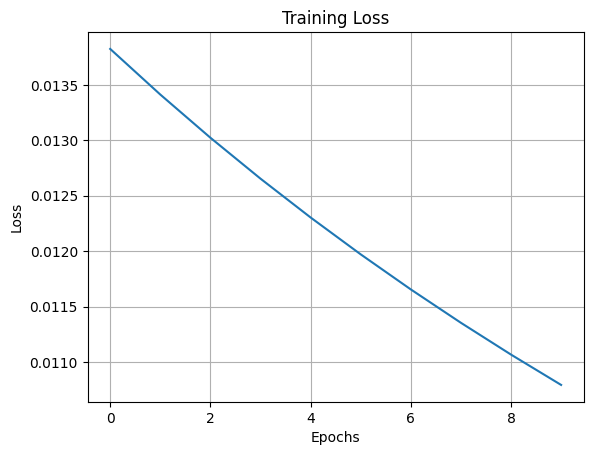

In [12]:
plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [14]:
encoder_model = Model(encoder_inputs, encoder_states)


In [16]:
dec_state_input_h = Input(shape=(128,))
dec_state_input_c = Input(shape=(128,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c]

dec_emb2 = model.get_layer('embedding_1')(decoder_inputs)
dec_outputs2, dh, dc = decoder_lstm(dec_emb2, initial_state=dec_states_inputs)
dec_states2 = [dh, dc]
dec_outputs2 = decoder_dense(dec_outputs2)

decoder_model = Model(
    [decoder_inputs] + dec_states_inputs,
    [dec_outputs2] + dec_states2
)

In [17]:
def translate(sentence):
    seq = eng_token.texts_to_sequences([sentence])
    seq = pad_sequences(seq, padding='post', maxlen=eng_padded.shape[1])

    states = encoder_model.predict(seq)

    target_seq = np.array([[1]])

    result = ""

    for _ in range(20):
        output, h, c = decoder_model.predict([target_seq] + states)

        token = np.argmax(output[0, -1, :])
        result += tam_token.index_word.get(token, "")

        if token == 0:
            break

        target_seq = np.array([[token]])
        states = [h, c]

    return result


In [18]:
print(translate("hello"))
print(translate("thank you"))
print(translate("good morning"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
வணக்கம்
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
நன்றி
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
காலைவணக்கம்
